In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Install & Import Libraries

In [2]:
# Installing necessary packages
!pip install xgboost lightgbm


In [3]:
#Importing Python Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression

import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')



 Load Dataset

In [4]:
#Loading Dataset
file_path = '/content/drive/MyDrive/Final Assessment Big Data/video_game_sales.csv'
data = pd.read_csv(file_path)

# Check dataset shape and sample records
print("Dataset Shape:", data.shape)
print("\nFirst 5 Entries:")
data.head()


Dataset Shape: (64016, 14)

First 5 Entries:


,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,eu_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,9/17/2013,NaN
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,11/18/2014,1/3/2018
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,10/28/2002,NaN
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,9/17/2013,NaN
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,11/6/2015,1/14/2018


In [5]:
#Dataset Info, Describe, and Missing Values
# Data types and info
data.info()

# Dataset statistics
data.describe()

# Check for missing values
print("\nMissing Values in Each Column:\n")
print(data.isnull().sum())

# See last 5 rows
data.tail()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img           64016 non-null  object 
 1   title         64016 non-null  object 
 2   console       64016 non-null  object 
 3   genre         64016 non-null  object 
 4   publisher     64016 non-null  object 
 5   developer     63999 non-null  object 
 6   critic_score  6678 non-null   float64
 7   total_sales   18922 non-null  float64
 8   na_sales      12637 non-null  float64
 9   jp_sales      6726 non-null   float64
 10  eu_sales      12824 non-null  float64
 11  other_sales   15128 non-null  float64
 12  release_date  56965 non-null  object 
 13  last_update   17879 non-null  object 
dtypes: float64(6), object(8)
memory usage: 6.8+ MB

Missing Values in Each Column:

img                 0
title               0
console             0
genre               0
publisher           0
develope

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,eu_sales,other_sales,release_date,last_update
64011,/games/boxart/full_2779838AmericaFrontccc.jpg,XBlaze Lost: Memories,PC,Visual Novel,Aksys Games,Arc System Works,NaN,NaN,NaN,NaN,NaN,NaN,8/11/2016,1/28/2019
64012,/games/boxart/full_8031506AmericaFrontccc.jpg,"Yoru, Tomosu",PS4,Visual Novel,Nippon Ichi Software,Nippon Ichi Software,NaN,NaN,NaN,NaN,NaN,NaN,7/30/2020,5/9/2020
64013,/games/boxart/full_6553045AmericaFrontccc.jpg,"Yoru, Tomosu",NS,Visual Novel,Nippon Ichi Software,Nippon Ichi Software,NaN,NaN,NaN,NaN,NaN,NaN,7/30/2020,5/9/2020
64014,/games/boxart/full_6012940JapanFrontccc.png,Yunohana SpRING! ~Mellow Times~,NS,Visual Novel,Idea Factory,Otomate,NaN,NaN,NaN,NaN,NaN,NaN,2/28/2019,2/24/2019
64015,/games/boxart/default.jpg,Yurukill: The Calumniation Games,PS4,Visual Novel,Unknown,G.rev Ltd.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9/29/2023


Data Cleaning

In [6]:
# Drop unnecessary columns
data.drop(columns=['img', 'developer', 'last_update', 'critic_score'], inplace=True)

# Convert release_date to datetime
data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')

# Drop rows without total_sales or release_date
data.dropna(subset=['total_sales', 'genre', 'publisher', 'release_date'], inplace=True)

# Fill missing regional sales with 0
for col in ['na_sales', 'jp_sales', 'eu_sales', 'other_sales']:
    data[col] = data[col].fillna(0)

# Confirm cleaned data
print(data.isnull().sum())
# Check data distributions after cleaning
print("\nSummary statistics after cleaning:")
data.describe()


title           0
console         0
genre           0
publisher       0
total_sales     0
na_sales        0
jp_sales        0
eu_sales        0
other_sales     0
release_date    0
dtype: int64

Summary statistics after cleaning:


,total_sales,na_sales,jp_sales,eu_sales,other_sales,release_date
count,18832.000000,18832.000000,18832.000000,18832.000000,18832.000000,18832
mean,0.350431,0.177610,0.036374,0.101669,0.034543,2008-04-02 22:17:32.166525184
min,0.000000,0.000000,0.000000,0.000000,0.000000,1977-01-01 00:00:00
25%,0.030000,0.000000,0.000000,0.000000,0.000000,2004-09-27 00:00:00
50%,0.120000,0.050000,0.000000,0.010000,0.010000,2008-10-21 00:00:00
75%,0.350000,0.170000,0.020000,0.070000,0.020000,2011-11-08 00:00:00
max,20.320000,9.760000,2.130000,9.850000,3.120000,2020-12-31 00:00:00
std,0.809039,0.423975,0.112079,0.331352,0.114771,NaN


Feature Engineering

In [7]:
data['release_year'] = data['release_date'].dt.year
data['release_decade'] = (data['release_year'] // 10) * 10
data['years_since_release'] = 2024 - data['release_year']

publisher_avg_sales = data.groupby('publisher')['total_sales'].mean()
data['publisher_avg_sales'] = data['publisher'].map(publisher_avg_sales)

le = LabelEncoder()
data['genre_code'] = le.fit_transform(data['genre'])
data['publisher_code'] = le.fit_transform(data['publisher'])
data['console_code'] = le.fit_transform(data['console'])
# Display the first 5 rows
data.head()


,title,console,genre,publisher,total_sales,na_sales,jp_sales,eu_sales,other_sales,release_date,release_year,release_decade,years_since_release,publisher_avg_sales,genre_code,publisher_code,console_code
0,Grand Theft Auto V,PS3,Action,Rockstar Games,20.32,6.37,0.99,9.85,3.12,2013-09-17,2013,2010,11,2.577097,0,541,22
1,Grand Theft Auto V,PS4,Action,Rockstar Games,19.39,6.06,0.60,9.71,3.02,2014-11-18,2014,2010,10,2.577097,0,541,23
2,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,16.15,8.41,0.47,5.49,1.78,2002-10-28,2002,2000,22,2.577097,0,541,21
3,Grand Theft Auto V,X360,Action,Rockstar Games,15.86,9.06,0.06,5.33,1.42,2013-09-17,2013,2010,11,2.577097,0,541,35
4,Call of Duty: Black Ops 3,PS4,Shooter,Activision,15.09,6.18,0.41,6.05,2.44,2015-11-06,2015,2010,9,0.692308,15,30,23


Visualizations

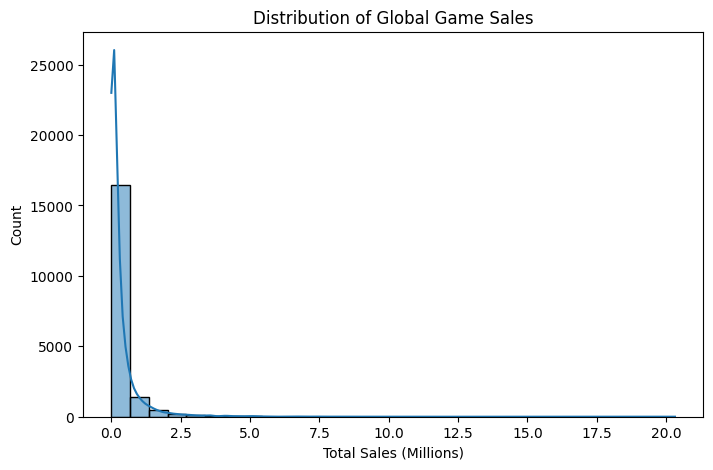

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(data['total_sales'], bins=30, kde=True)
plt.title("Distribution of Global Game Sales")
plt.xlabel("Total Sales (Millions)")
plt.ylabel("Count")
plt.show()


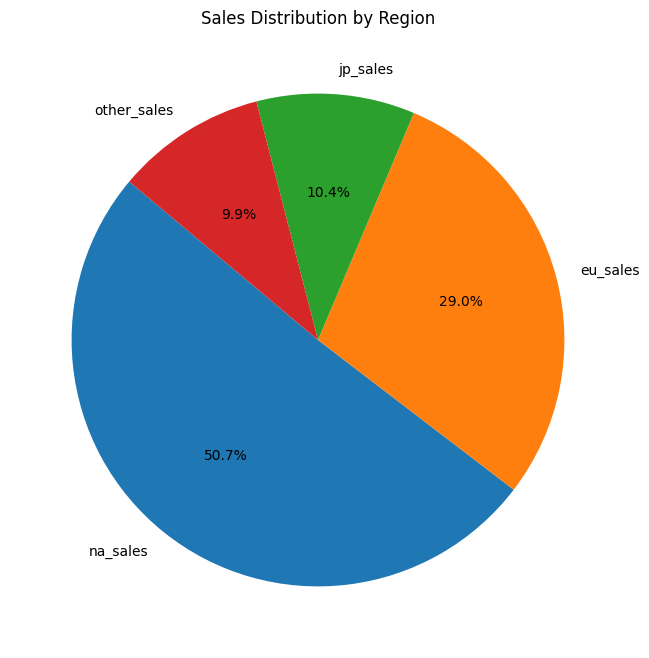

In [9]:
region_totals = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum()
plt.figure(figsize=(8,8))
plt.pie(region_totals, labels=region_totals.index, autopct='%1.1f%%', startangle=140)
plt.title('Sales Distribution by Region')
plt.show()


Text(0, 0.5, 'Game Title')

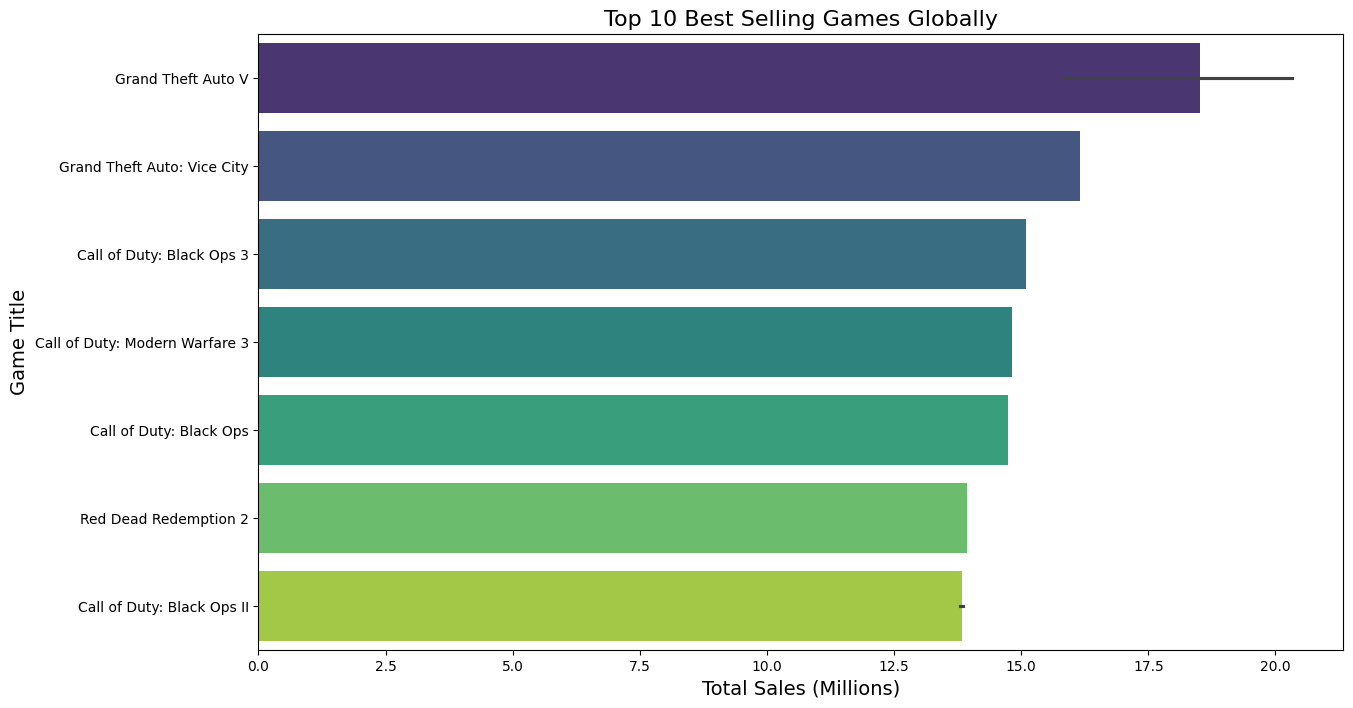

In [10]:
# 3. Top 10 Best Selling Games Globally
top_games = data[['title', 'total_sales']].sort_values(by='total_sales', ascending=False).head(10)
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='total_sales', y='title', data=top_games, palette='viridis')
plt.title("Top 10 Best Selling Games Globally", fontsize=16)
plt.xlabel("Total Sales (Millions)", fontsize=14)
plt.ylabel("Game Title", fontsize=14)

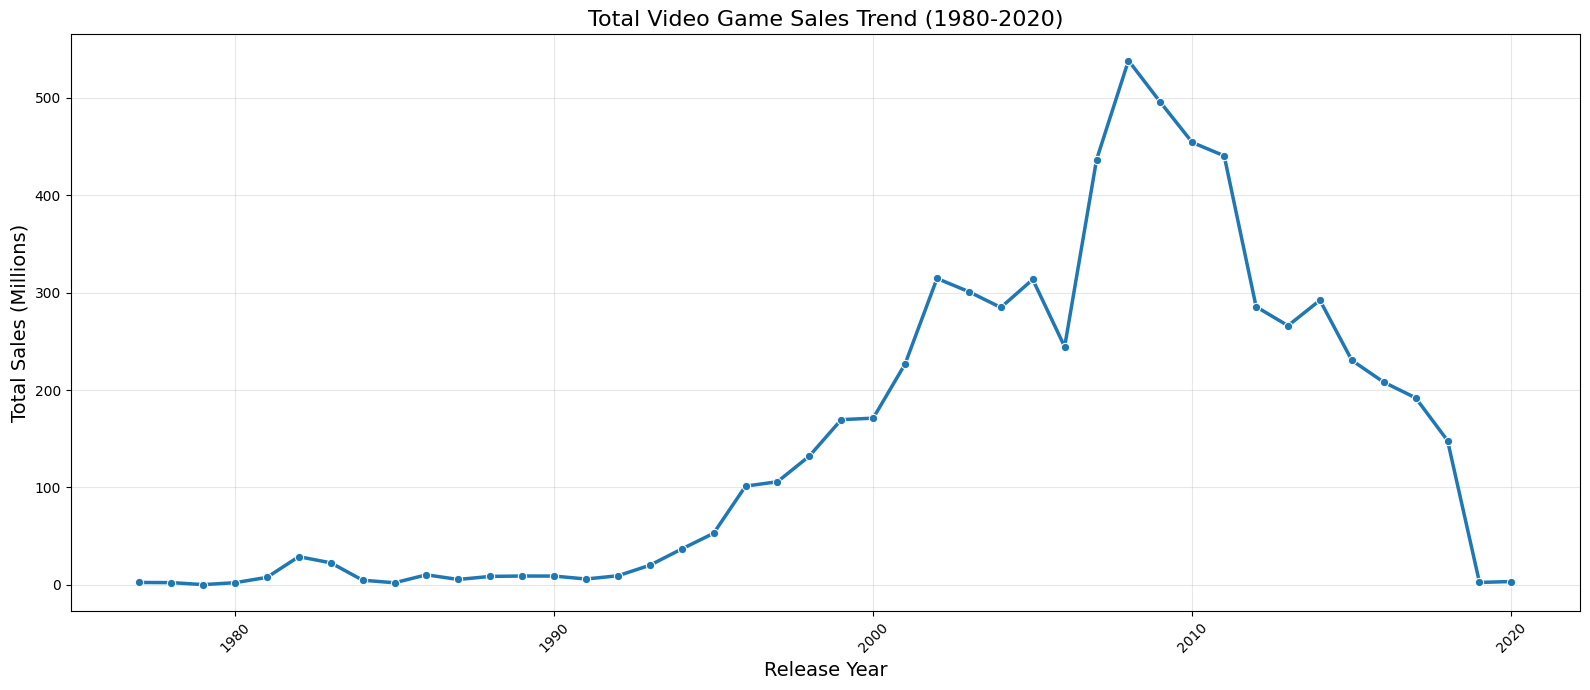

In [11]:
# 4. Total Sales Trend Over Years
sales_by_year = data.groupby('release_year')['total_sales'].sum().reset_index()
plt.figure(figsize=(16, 7))
sns.lineplot(x='release_year', y='total_sales', data=sales_by_year, linewidth=2.5, marker='o')
plt.title("Total Video Game Sales Trend (1980-2020)", fontsize=16)
plt.xlabel("Release Year", fontsize=14)
plt.ylabel("Total Sales (Millions)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

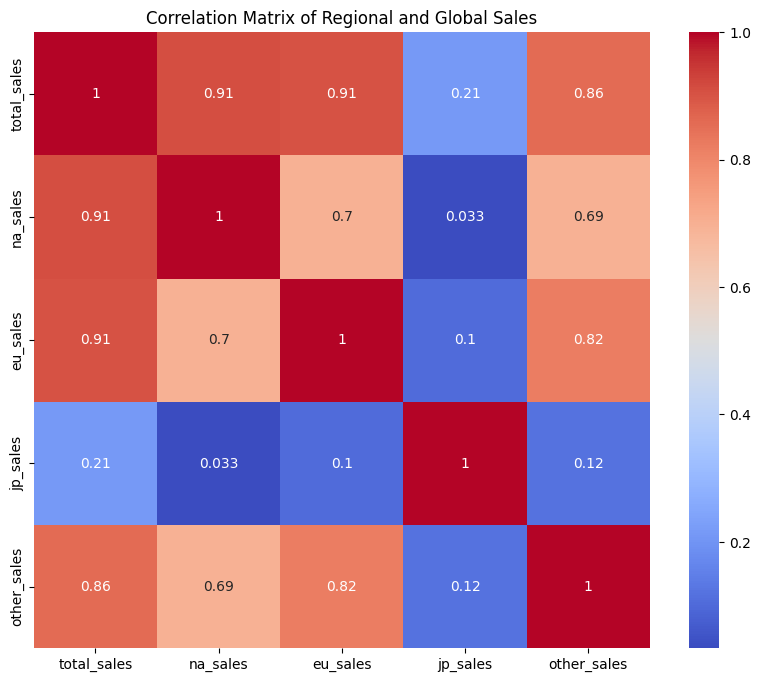

In [12]:
plt.figure(figsize=(10,8))
corr = data[['total_sales', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Matrix of Regional and Global Sales")
plt.show()

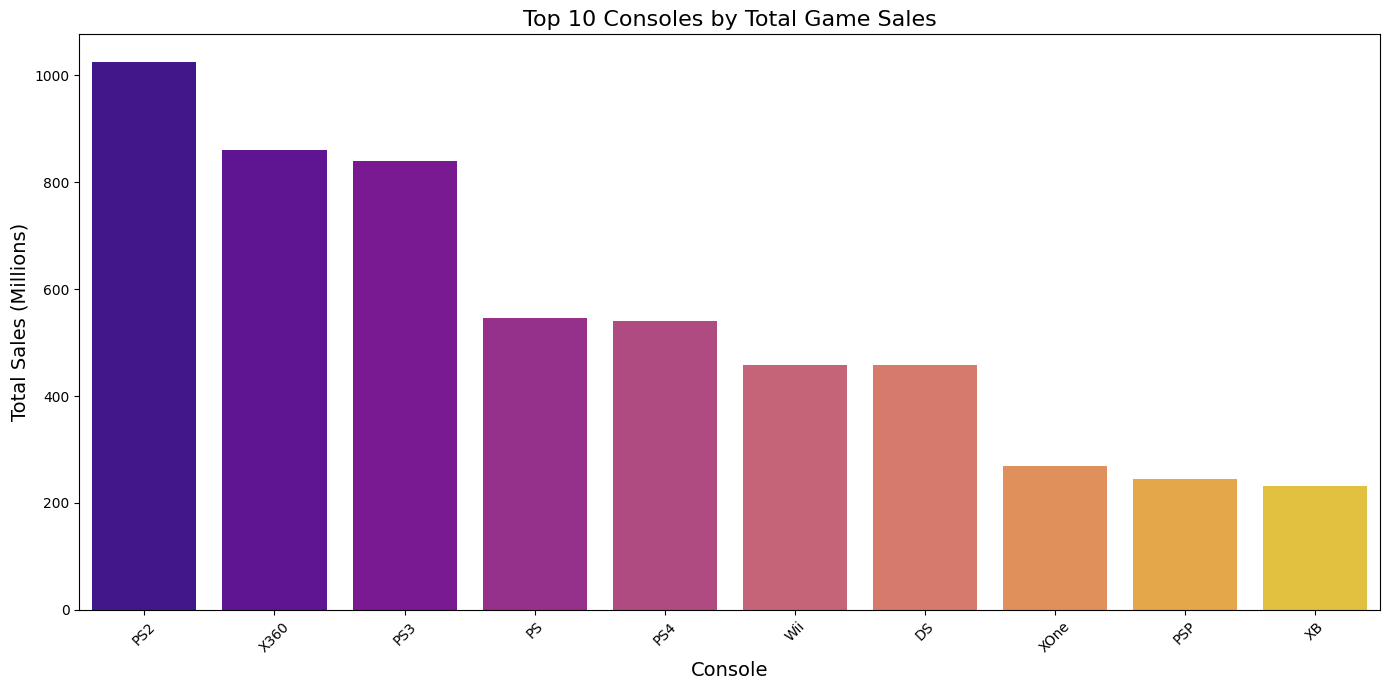

In [13]:
#Sales by Console (Top 10)
console_sales = data.groupby('console')['total_sales'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(14, 7))
sns.barplot(x=console_sales.index, y=console_sales.values, palette='plasma')
plt.title("Top 10 Consoles by Total Game Sales", fontsize=16)
plt.xlabel("Console", fontsize=14)
plt.ylabel("Total Sales (Millions)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

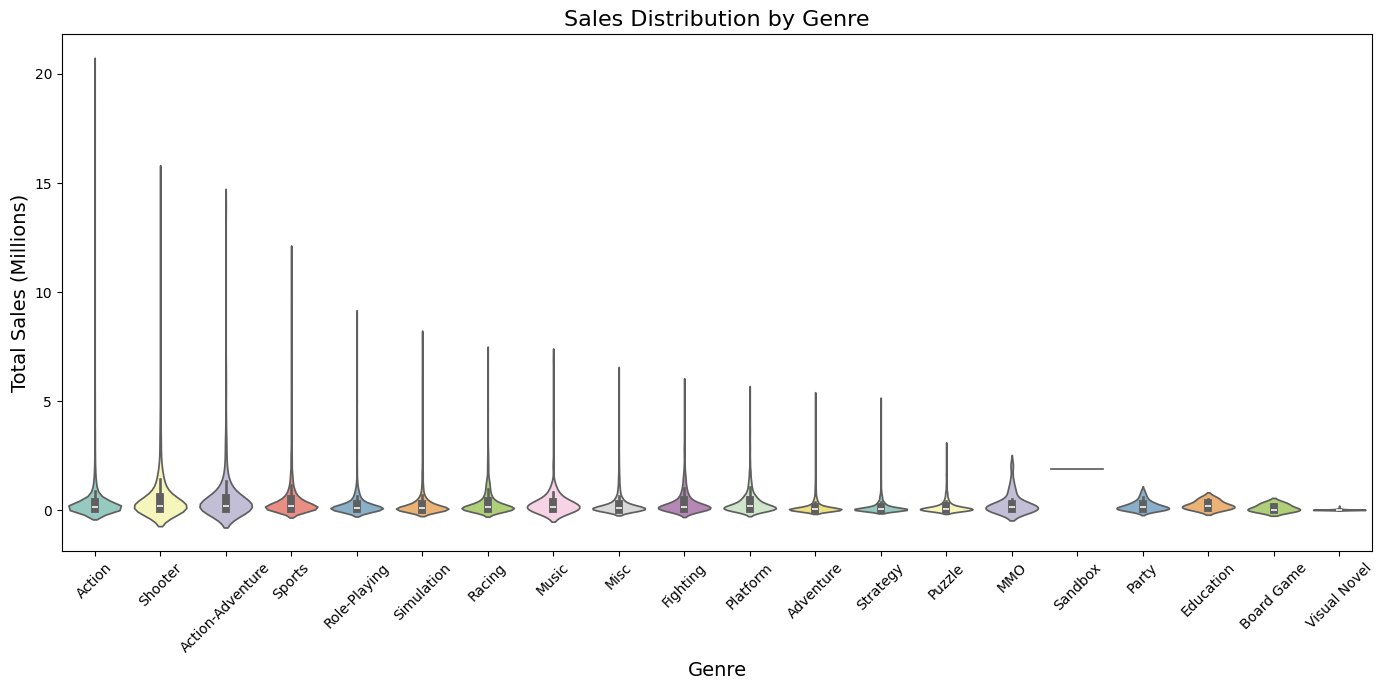

In [14]:
#Sales Distribution by Genre
plt.figure(figsize=(14, 7))
sns.violinplot(x='genre', y='total_sales', data=data, palette='Set3')
plt.title("Sales Distribution by Genre", fontsize=16)
plt.xlabel("Genre", fontsize=14)
plt.ylabel("Total Sales (Millions)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

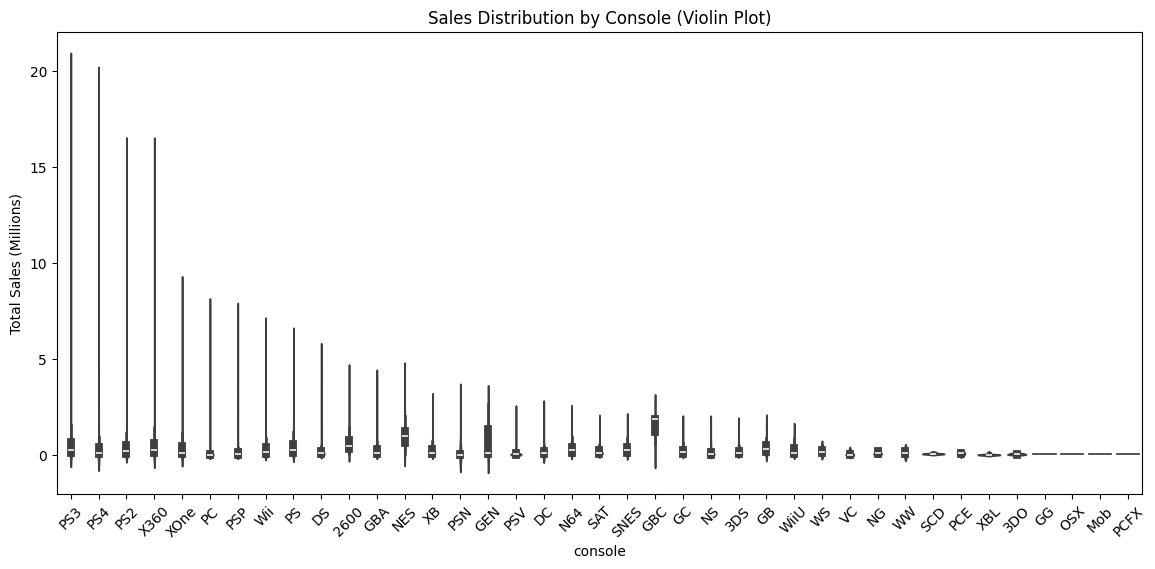

In [15]:
plt.figure(figsize=(14,6))
sns.violinplot(x='console', y='total_sales', data=data)
plt.xticks(rotation=45)
plt.title("Sales Distribution by Console (Violin Plot)")
plt.ylabel("Total Sales (Millions)")
plt.show()


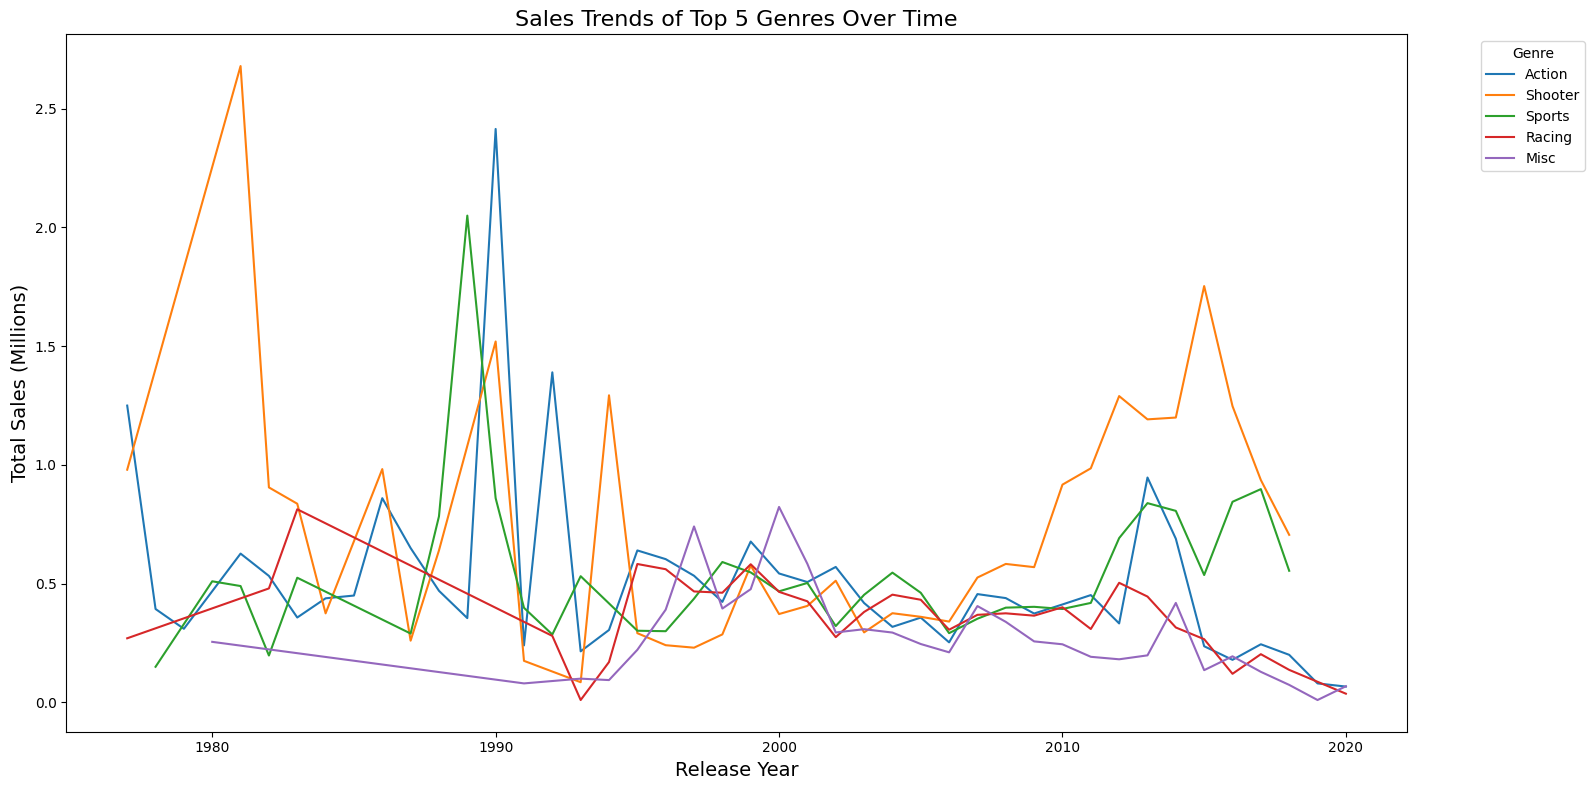

In [16]:
#Year vs Sales by Genre
plt.figure(figsize=(16, 8))
top_genres = data.groupby('genre')['total_sales'].sum().sort_values(ascending=False).head(5).index
genre_year_data = data[data['genre'].isin(top_genres)]
sns.lineplot(x='release_year', y='total_sales', hue='genre', data=genre_year_data, ci=None)
plt.title("Sales Trends of Top 5 Genres Over Time", fontsize=16)
plt.xlabel("Release Year", fontsize=14)
plt.ylabel("Total Sales (Millions)", fontsize=14)
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

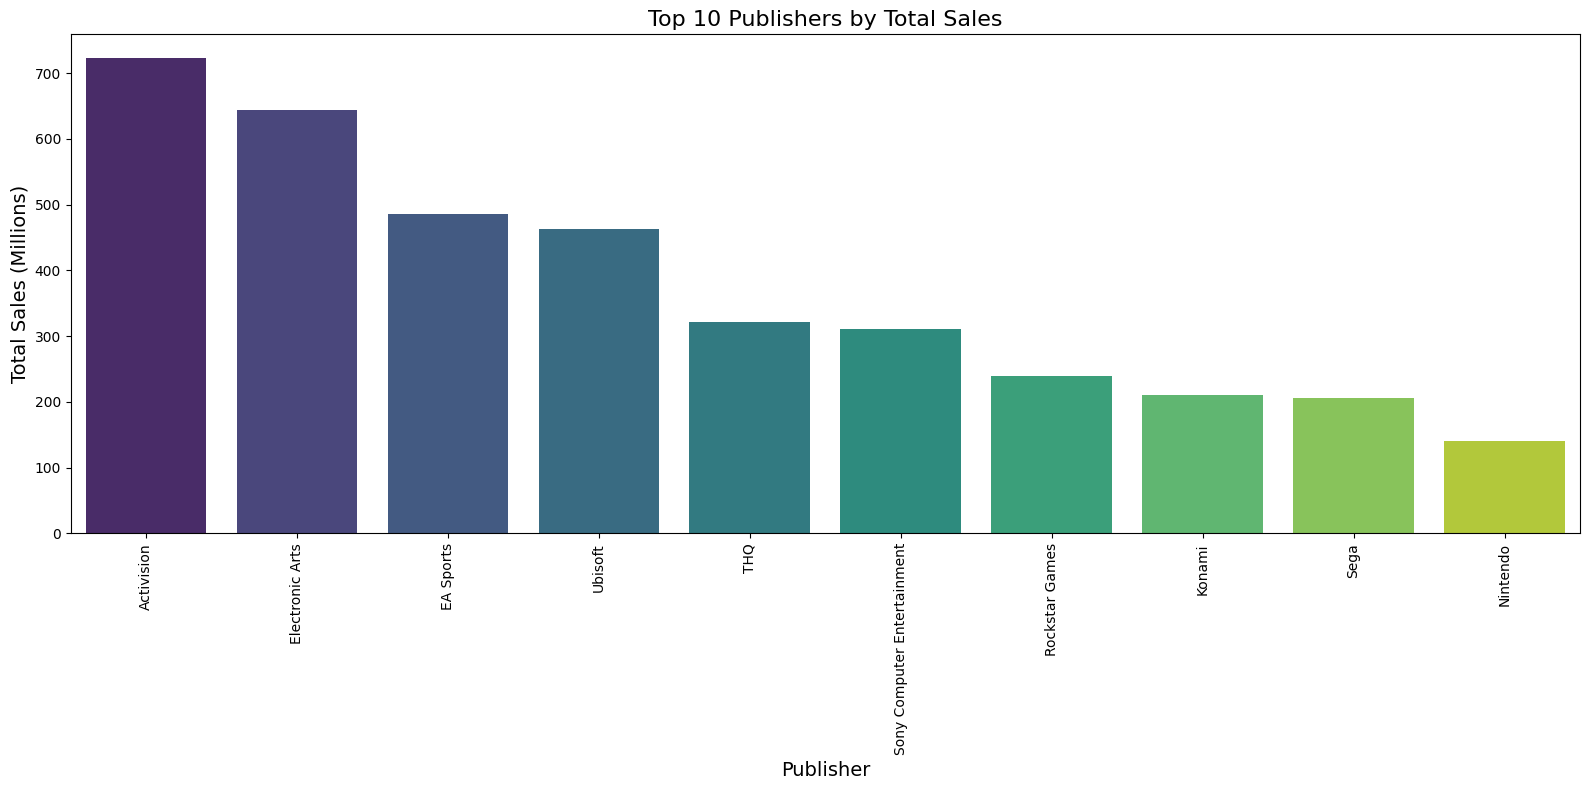

In [17]:
#Publisher Analysis - Top 15
top_publishers = data.groupby('publisher')['total_sales'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(16, 8))
sns.barplot(x=top_publishers.index, y=top_publishers.values, palette='viridis')
plt.title("Top 10 Publishers by Total Sales", fontsize=16)
plt.xlabel("Publisher", fontsize=14)
plt.ylabel("Total Sales (Millions)", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


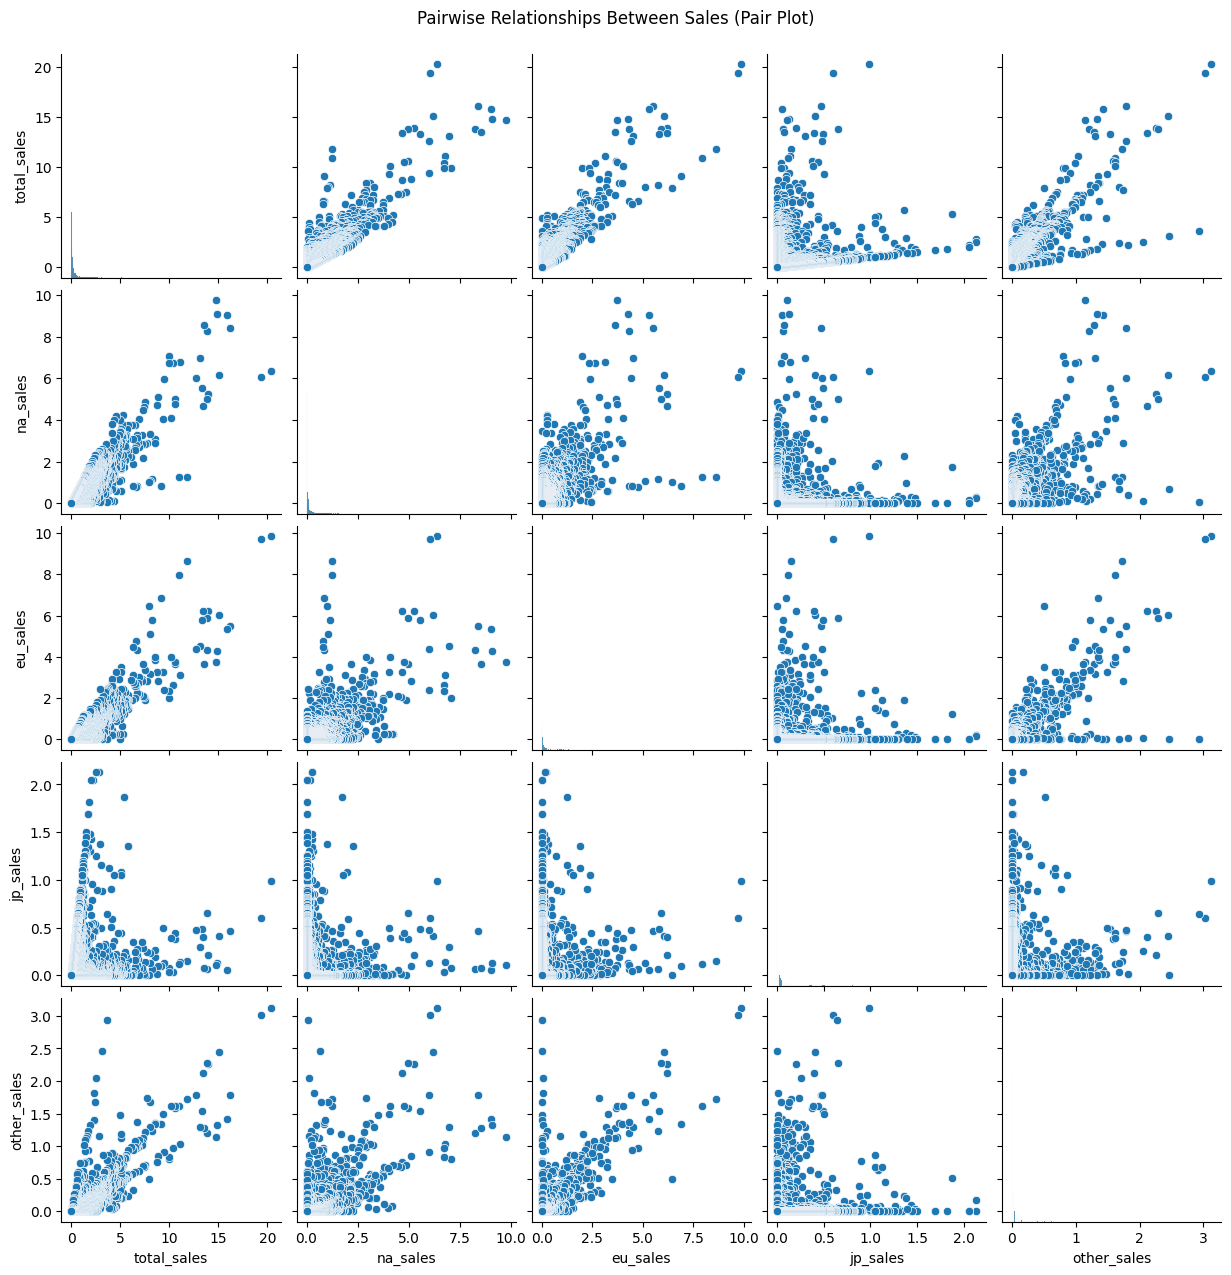

In [18]:
sns.pairplot(data[['total_sales', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales']])
plt.suptitle("Pairwise Relationships Between Sales (Pair Plot)", y=1.02)
plt.show()


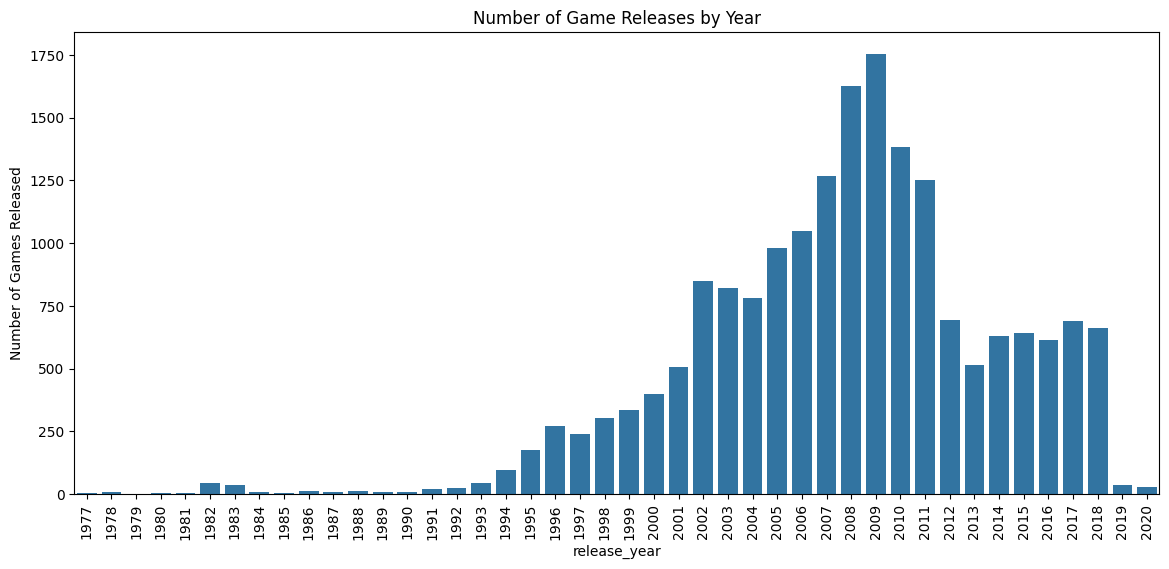

In [19]:
plt.figure(figsize=(14,6))
sns.countplot(x='release_year', data=data)
plt.xticks(rotation=90)
plt.title("Number of Game Releases by Year")
plt.ylabel("Number of Games Released")
plt.show()


Hybrid Feature Selection

In [20]:
features = ['release_decade', 'years_since_release', 'publisher_avg_sales', 'console_code', 'genre_code', 'publisher_code']
target = 'total_sales'
X = data[features]
y = data[target]

mi_scores = mutual_info_regression(X, y)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print(mi_series)

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, y)
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(rf_importances)

top_features = list(mi_series.head(5).index.union(rf_importances.head(5).index))
print("Selected Features:", top_features)


publisher_avg_sales    0.287130
publisher_code         0.194622
console_code           0.145321
genre_code             0.058312
years_since_release    0.047845
release_decade         0.036541
dtype: float64
years_since_release    0.316313
publisher_avg_sales    0.257766
genre_code             0.175609
console_code           0.161443
publisher_code         0.071014
release_decade         0.017856
dtype: float64
Selected Features: ['console_code', 'genre_code', 'publisher_avg_sales', 'publisher_code', 'years_since_release']


In [21]:
# Features to consider for selection (all numeric + encoded features)
features = [
    'release_decade', 'years_since_release', 'publisher_avg_sales',
    'console_code', 'genre_code', 'publisher_code',
    'na_sales', 'eu_sales', 'jp_sales', 'other_sales'
]

# Target variable
target = 'total_sales'

# Split data into X (features) and y (target)
X = data[features]
y = data[target]

#  Mutual Information Scores
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X, y)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print("\n📊 Mutual Information Scores:")
print(mi_series)

# Random Forest Feature Importances
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n📊 Random Forest Feature Importances:")
print(rf_importances)

# Hybrid Feature Selection — Union of Top 7 Features from Each
top_mi = list(mi_series.head(7).index)
top_rf = list(rf_importances.head(7).index)
top_features = list(set(top_mi).union(set(top_rf)))

print("\nFinal Selected Features (Hybrid Selection):")
print(top_features)



📊 Mutual Information Scores:
na_sales               1.118192
other_sales            0.748717
eu_sales               0.704706
jp_sales               0.566967
publisher_avg_sales    0.288143
publisher_code         0.193258
console_code           0.149177
years_since_release    0.061800
genre_code             0.059825
release_decade         0.032708
dtype: float64

📊 Random Forest Feature Importances:
eu_sales               0.524568
na_sales               0.359775
other_sales            0.095503
jp_sales               0.017138
years_since_release    0.001406
console_code           0.000395
publisher_avg_sales    0.000393
genre_code             0.000385
publisher_code         0.000330
release_decade         0.000107
dtype: float64

Final Selected Features (Hybrid Selection):
['jp_sales', 'na_sales', 'console_code', 'publisher_code', 'publisher_avg_sales', 'other_sales', 'years_since_release', 'eu_sales']


Model Training & Evaluation (XGBoost + LightGBM)

Split by Region (Example for NA)

In [22]:
# Define target variables for each region
y_na = data['na_sales']
y_eu = data['eu_sales']
y_jp = data['jp_sales']
y_other = data['other_sales']

# Split data for each region using same top features
X_train_na, X_test_na, y_train_na, y_test_na = train_test_split(data[top_features], y_na, test_size=0.2, random_state=42)
X_train_eu, X_test_eu, y_train_eu, y_test_eu = train_test_split(data[top_features], y_eu, test_size=0.2, random_state=42)
X_train_jp, X_test_jp, y_train_jp, y_test_jp = train_test_split(data[top_features], y_jp, test_size=0.2, random_state=42)
X_train_other, X_test_other, y_train_other, y_test_other = train_test_split(data[top_features], y_other, test_size=0.2, random_state=42)


XGBoost

In [23]:
# XGBoost models for each region
xg_na = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xg_eu = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xg_jp = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xg_other = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Fit models
xg_na.fit(X_train_na, y_train_na)
xg_eu.fit(X_train_eu, y_train_eu)
xg_jp.fit(X_train_jp, y_train_jp)
xg_other.fit(X_train_other, y_train_other)

# Make predictions
pred_na = xg_na.predict(X_test_na)
pred_eu = xg_eu.predict(X_test_eu)
pred_jp = xg_jp.predict(X_test_jp)
pred_other = xg_other.predict(X_test_other)


In [24]:
def evaluate_model(y_true, y_pred, region):
    print(f"\n{region} Sales Model Performance")
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("R² Score:", r2_score(y_true, y_pred))

# Evaluate each model
evaluate_model(y_test_na, pred_na, "North America")
evaluate_model(y_test_eu, pred_eu, "Europe")
evaluate_model(y_test_jp, pred_jp, "Japan")
evaluate_model(y_test_other, pred_other, "Other")



North America Sales Model Performance
RMSE: 0.04937434990752346
MAE: 0.0036678610132645857
R² Score: 0.9852659191039462

Europe Sales Model Performance
RMSE: 0.019773250430655143
MAE: 0.0008681756063378129
R² Score: 0.9970531448913872

Japan Sales Model Performance
RMSE: 0.0014117528904273602
MAE: 0.00010169154262503788
R² Score: 0.999817156376733

Other Sales Model Performance
RMSE: 0.0059324135485454245
MAE: 0.00026190122310377014
R² Score: 0.997944798342708


 LightGBM Implementation - Regional Models

In [25]:
# Initialize LightGBM models for regional sales
print("Training LightGBM models for regional sales...")
lgb_na = lgb.LGBMRegressor(random_state=42)
lgb_eu = lgb.LGBMRegressor(random_state=42)
lgb_jp = lgb.LGBMRegressor(random_state=42)
lgb_other = lgb.LGBMRegressor(random_state=42)

# Fit models
lgb_na.fit(X_train_na, y_train_na)
lgb_eu.fit(X_train_eu, y_train_eu)
lgb_jp.fit(X_train_jp, y_train_jp)
lgb_other.fit(X_train_other, y_train_other)

# Make predictions
lgb_pred_na = lgb_na.predict(X_test_na)
lgb_pred_eu = lgb_eu.predict(X_test_eu)
lgb_pred_jp = lgb_jp.predict(X_test_jp)
lgb_pred_other = lgb_other.predict(X_test_other)

Training LightGBM models for regional sales...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1119
[LightGBM] [Info] Number of data points in the train set: 15065, number of used features: 8
[LightGBM] [Info] Start training from score 0.178574
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1119
[LightGBM] [Info] Number of data points in the train set: 15065, number of used features: 8
[LightGBM] [Info] Start training from score 0.101817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_row_wise=true` to re

Evaluating Model Performance

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(y_true, y_pred, region_name):
    print(f"\nEvaluation for {region_name}:")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("MSE:", mean_squared_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R² Score:", r2_score(y_true, y_pred))

# Evaluate each model
evaluate_model(y_test_na, lgb_pred_na, "North America")
evaluate_model(y_test_eu, lgb_pred_eu, "Europe")
evaluate_model(y_test_jp, lgb_pred_jp, "Japan")
evaluate_model(y_test_other, lgb_pred_other, "Other Regions")


Evaluation for North America:
MAE: 0.00168652570749859
MSE: 0.0018757912907900985
RMSE: 0.043310406264431396
R² Score: 0.988662826731136

Evaluation for Europe:
MAE: 0.003778675480046105
MSE: 0.006317010199114932
RMSE: 0.07947962128190428
R² Score: 0.9523882409122488

Evaluation for Japan:
MAE: 0.0003704955440251026
MSE: 8.306530361854277e-05
RMSE: 0.009114016876138796
R² Score: 0.9923795239160427

Evaluation for Other Regions:
MAE: 0.0012391774153623384
MSE: 0.0007849821508620807
RMSE: 0.028017532918907774
R² Score: 0.9541592845624365


Global Sales Target

In [27]:
# Define target for global sales prediction
print("Preparing data for global sales prediction...")
y_global = data['total_sales']

# Split data for global sales prediction
X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(
    data[top_features], y_global, test_size=0.2, random_state=42
)

# Train XGBoost model for global sales
print("Training XGBoost model for global sales...")
xg_global = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xg_global.fit(X_train_global, y_train_global)

# Predict global sales
pred_global = xg_global.predict(X_test_global)

# Evaluate global model
print("\nXGBoost Global Sales Model Performance")
print("RMSE:", np.sqrt(mean_squared_error(y_test_global, pred_global)))
print("MAE:", mean_absolute_error(y_test_global, pred_global))
print("R² Score:", r2_score(y_test_global, pred_global))

Preparing data for global sales prediction...
Training XGBoost model for global sales...

XGBoost Global Sales Model Performance
RMSE: 0.07709569403754273
MAE: 0.01421269291784589
R² Score: 0.9912260376923444


LightGBM Implementation - Global Model

In [28]:
# Train LightGBM model for global sales
print("Training LightGBM model for global sales...")
lgb_global = lgb.LGBMRegressor(random_state=42)
lgb_global.fit(X_train_global, y_train_global)

# Predict global sales with LightGBM
lgb_pred_global = lgb_global.predict(X_test_global)

# Evaluate model
print("\nLightGBM Global Sales Model Performance")
print("RMSE:", np.sqrt(mean_squared_error(y_test_global, lgb_pred_global)))
print("MAE:", mean_absolute_error(y_test_global, lgb_pred_global))
print("R² Score:", r2_score(y_test_global, lgb_pred_global))

Training LightGBM model for global sales...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1119
[LightGBM] [Info] Number of data points in the train set: 15065, number of used features: 8
[LightGBM] [Info] Start training from score 0.351276

LightGBM Global Sales Model Performance
RMSE: 0.12219127672332357
MAE: 0.015757139482560644
R² Score: 0.9779597800280491


Model Performance Comparison Function


In [31]:
# Function to evaluate model performance and store results
def evaluate_model(y_true, y_pred, region, model_type):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_type} - {region} Sales Model Performance")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

Collecting Model Performance Metrics

In [32]:
# Store evaluation metrics for comparison
results = {}

# Evaluate XGBoost models and store results
print("Evaluating model performance...")
results['XGB_NA'] = evaluate_model(y_test_na, pred_na, "North America", "XGBoost")
results['XGB_EU'] = evaluate_model(y_test_eu, pred_eu, "Europe", "XGBoost")
results['XGB_JP'] = evaluate_model(y_test_jp, pred_jp, "Japan", "XGBoost")
results['XGB_OTHER'] = evaluate_model(y_test_other, pred_other, "Other Regions", "XGBoost")
results['XGB_GLOBAL'] = evaluate_model(y_test_global, pred_global, "Global", "XGBoost")

# Evaluate LightGBM models and store results
results['LGB_NA'] = evaluate_model(y_test_na, lgb_pred_na, "North America", "LightGBM")
results['LGB_EU'] = evaluate_model(y_test_eu, lgb_pred_eu, "Europe", "LightGBM")
results['LGB_JP'] = evaluate_model(y_test_jp, lgb_pred_jp, "Japan", "LightGBM")
results['LGB_OTHER'] = evaluate_model(y_test_other, lgb_pred_other, "Other Regions", "LightGBM")
results['LGB_GLOBAL'] = evaluate_model(y_test_global, lgb_pred_global, "Global", "LightGBM")

Evaluating model performance...

XGBoost - North America Sales Model Performance
RMSE: 0.0494
MAE: 0.0037
R² Score: 0.9853

XGBoost - Europe Sales Model Performance
RMSE: 0.0198
MAE: 0.0009
R² Score: 0.9971

XGBoost - Japan Sales Model Performance
RMSE: 0.0014
MAE: 0.0001
R² Score: 0.9998

XGBoost - Other Regions Sales Model Performance
RMSE: 0.0059
MAE: 0.0003
R² Score: 0.9979

XGBoost - Global Sales Model Performance
RMSE: 0.0771
MAE: 0.0142
R² Score: 0.9912

LightGBM - North America Sales Model Performance
RMSE: 0.0433
MAE: 0.0017
R² Score: 0.9887

LightGBM - Europe Sales Model Performance
RMSE: 0.0795
MAE: 0.0038
R² Score: 0.9524

LightGBM - Japan Sales Model Performance
RMSE: 0.0091
MAE: 0.0004
R² Score: 0.9924

LightGBM - Other Regions Sales Model Performance
RMSE: 0.0280
MAE: 0.0012
R² Score: 0.9542

LightGBM - Global Sales Model Performance
RMSE: 0.1222
MAE: 0.0158
R² Score: 0.9780


 Preparing Data for Visualization

In [33]:
# Convert results to DataFrame for visualization
regions = ['North America', 'Europe', 'Japan', 'Other Regions', 'Global']

# Create DataFrame for R2 scores
r2_data = {
    'Region': regions * 2,
    'Model': ['XGBoost'] * 5 + ['LightGBM'] * 5,
    'R2 Score': [
        results['XGB_NA']['R2'], results['XGB_EU']['R2'],
        results['XGB_JP']['R2'], results['XGB_OTHER']['R2'], results['XGB_GLOBAL']['R2'],
        results['LGB_NA']['R2'], results['LGB_EU']['R2'],
        results['LGB_JP']['R2'], results['LGB_OTHER']['R2'], results['LGB_GLOBAL']['R2']
    ]
}
r2_df = pd.DataFrame(r2_data)

# Create DataFrame for RMSE scores
rmse_data = {
    'Region': regions * 2,
    'Model': ['XGBoost'] * 5 + ['LightGBM'] * 5,
    'RMSE': [
        results['XGB_NA']['RMSE'], results['XGB_EU']['RMSE'],
        results['XGB_JP']['RMSE'], results['XGB_OTHER']['RMSE'], results['XGB_GLOBAL']['RMSE'],
        results['LGB_NA']['RMSE'], results['LGB_EU']['RMSE'],
        results['LGB_JP']['RMSE'], results['LGB_OTHER']['RMSE'], results['LGB_GLOBAL']['RMSE']
    ]
}
rmse_df = pd.DataFrame(rmse_data)

 R² Score Comparison Visualization


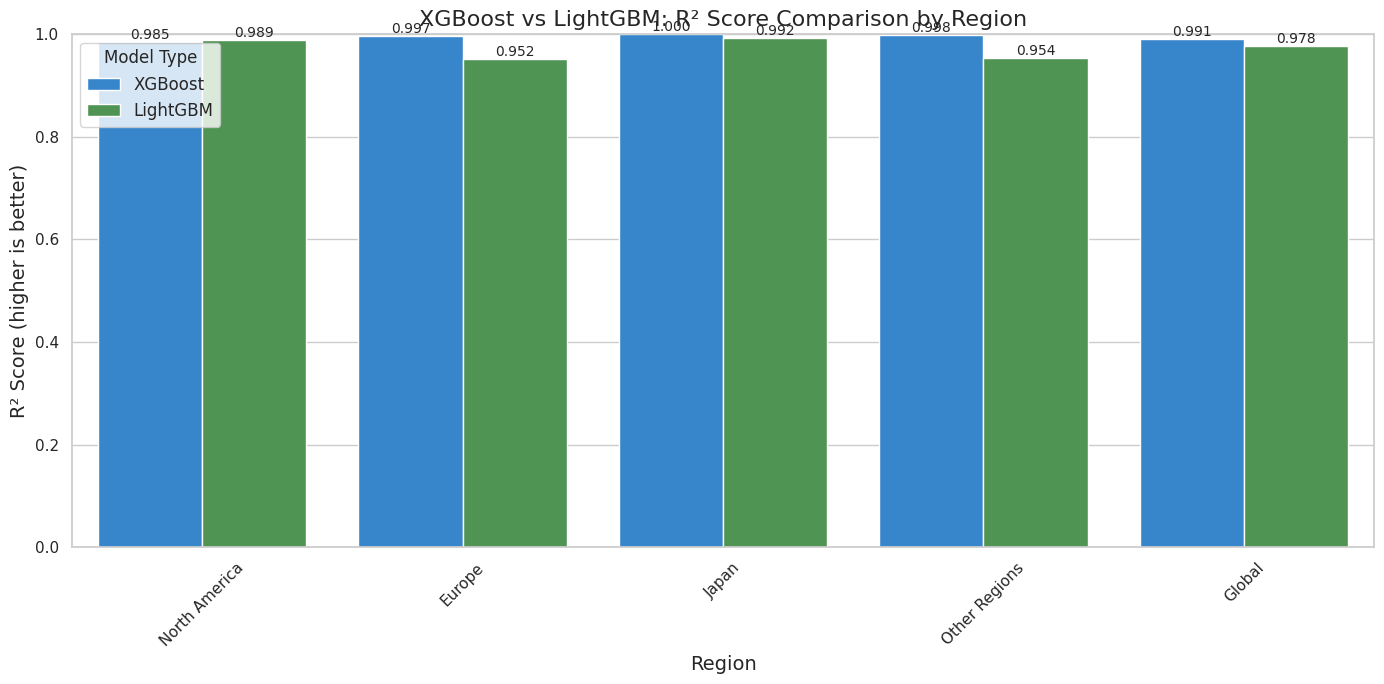

In [34]:
# Visualize R2 Scores Comparison
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")
ax = sns.barplot(x='Region', y='R2 Score', hue='Model', data=r2_df, palette=['#1E88E5', '#43A047'])
plt.title('XGBoost vs LightGBM: R² Score Comparison by Region', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.ylabel('R² Score (higher is better)', fontsize=14)
plt.ylim(0, 1)  # R2 score range
plt.xticks(rotation=45)
plt.legend(title='Model Type', fontsize=12)

# Add value labels on bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.3f', fontsize=10)

plt.tight_layout()
plt.show()

 RMSE Comparison Visualization

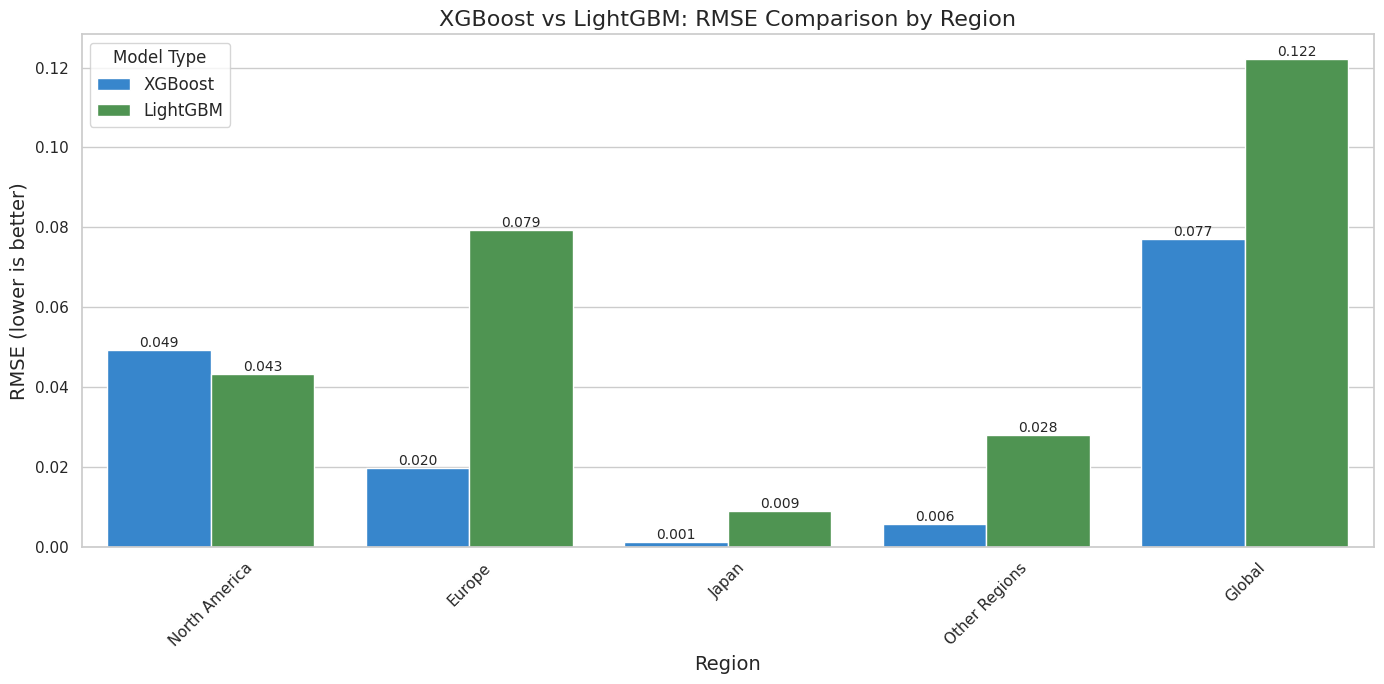

In [35]:
# Visualize RMSE Comparison
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")
ax = sns.barplot(x='Region', y='RMSE', hue='Model', data=rmse_df, palette=['#1E88E5', '#43A047'])
plt.title('XGBoost vs LightGBM: RMSE Comparison by Region', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.ylabel('RMSE (lower is better)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Model Type', fontsize=12)

# Add value labels on bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.3f', fontsize=10)

plt.tight_layout()
plt.show()

 Model Comparison Function for Scatter Plots

In [36]:
# Function to compare actual vs predicted values for both models
def plot_model_comparison(y_true, xgb_pred, lgb_pred, region_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # XGBoost plot
    ax1.scatter(y_true, xgb_pred, alpha=0.6, color='#1E88E5')
    ax1.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    ax1.set_title(f'XGBoost: {region_name} Sales Prediction', fontsize=14)
    ax1.set_xlabel('Actual Sales', fontsize=12)
    ax1.set_ylabel('Predicted Sales', fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Add R² annotation
    r2_xgb = r2_score(y_true, xgb_pred)
    ax1.annotate(f'R² = {r2_xgb:.4f}',
                xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc='#F8F9F9', ec="gray", alpha=0.8))

    # LightGBM plot
    ax2.scatter(y_true, lgb_pred, alpha=0.6, color='#43A047')
    ax2.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    ax2.set_title(f'LightGBM: {region_name} Sales Prediction', fontsize=14)
    ax2.set_xlabel('Actual Sales', fontsize=12)
    ax2.set_ylabel('Predicted Sales', fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Add R² annotation
    r2_lgb = r2_score(y_true, lgb_pred)
    ax2.annotate(f'R² = {r2_lgb:.4f}',
                xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc='#F8F9F9', ec="gray", alpha=0.8))

    plt.suptitle(f'XGBoost vs LightGBM: {region_name} Sales Prediction Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()

 Creating Comparison Scatter Plots for All Regions

Generating model comparison visualizations...


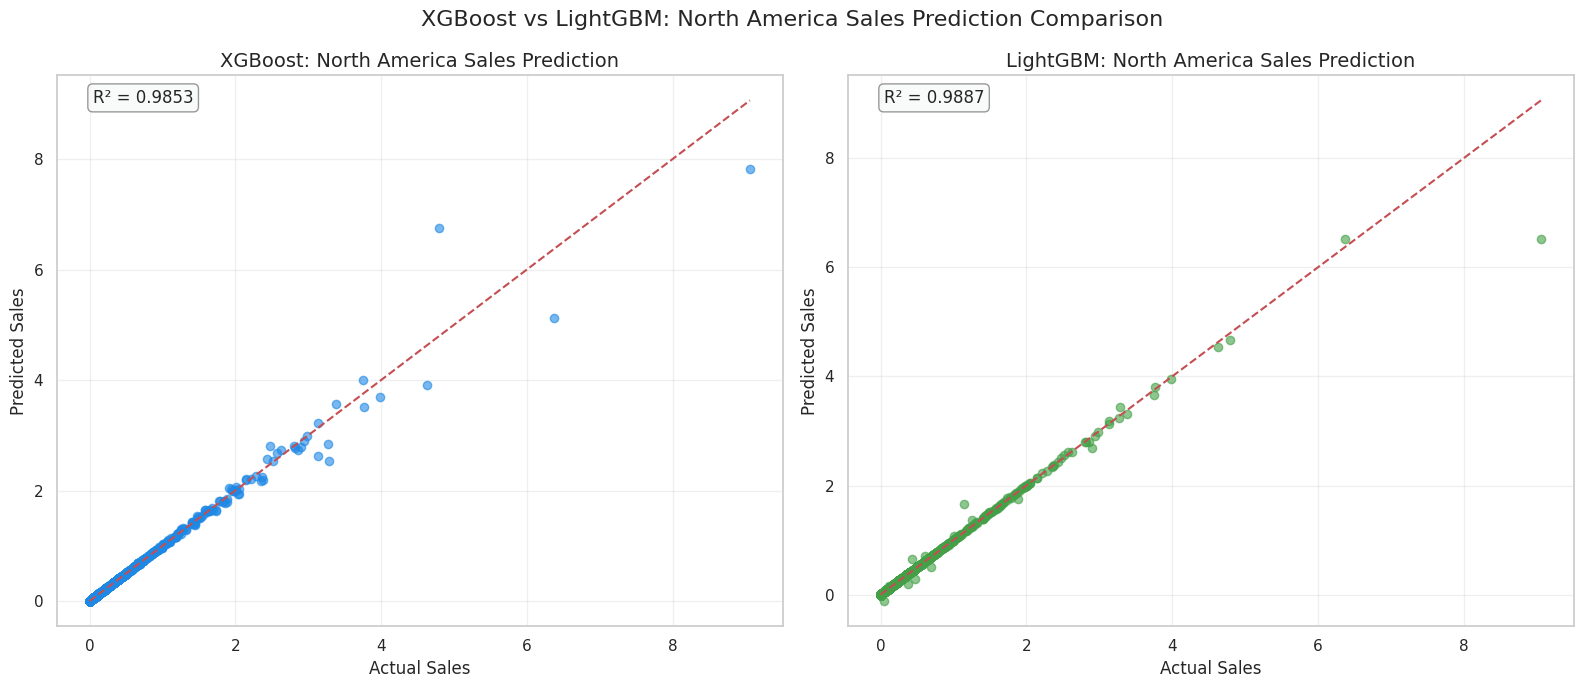

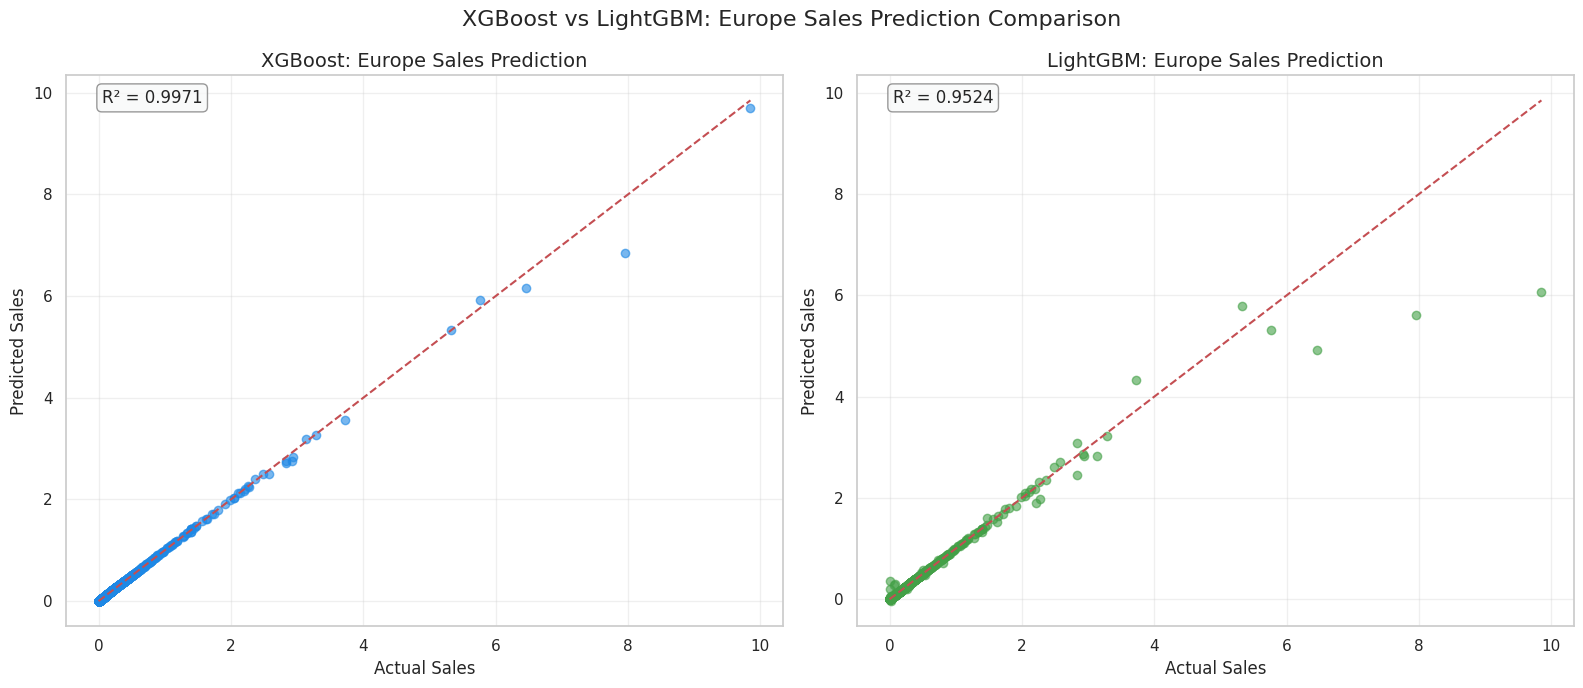

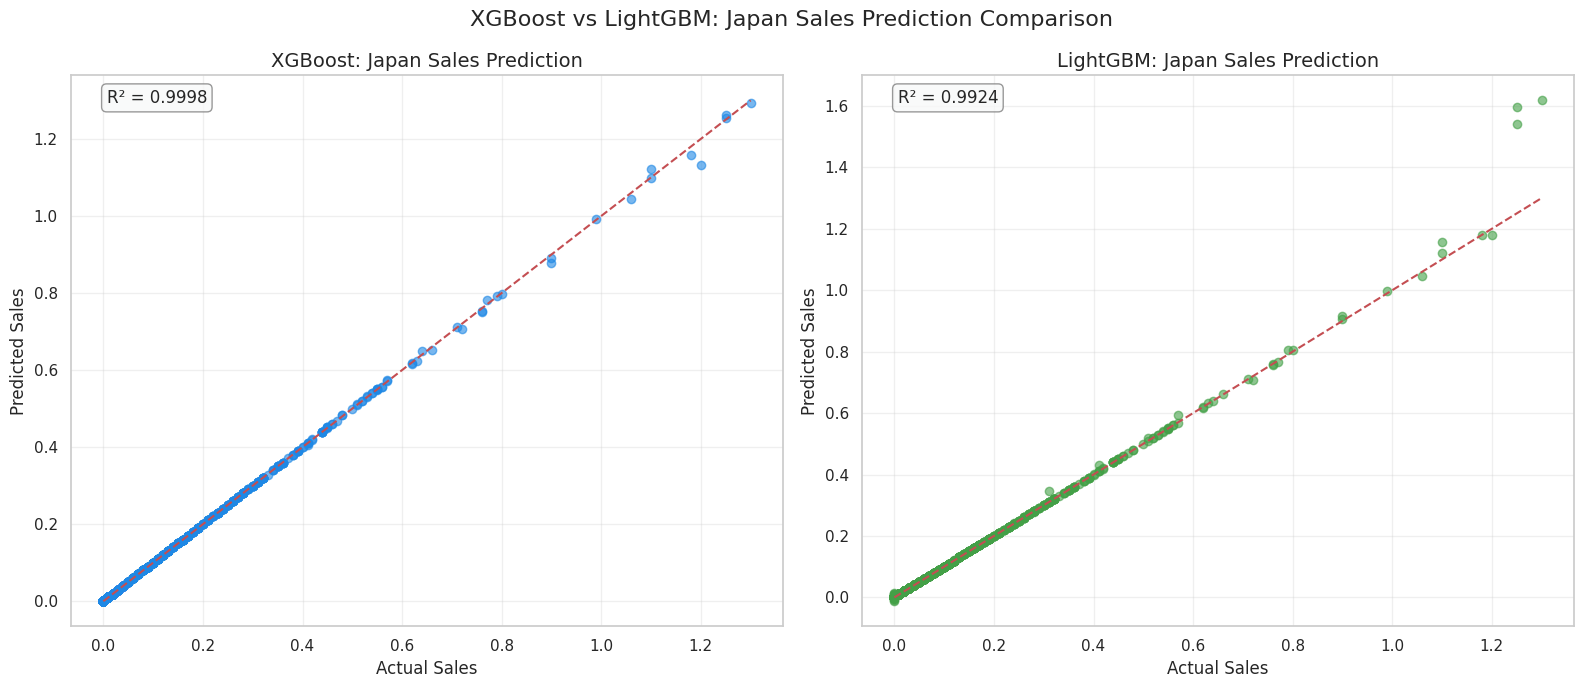

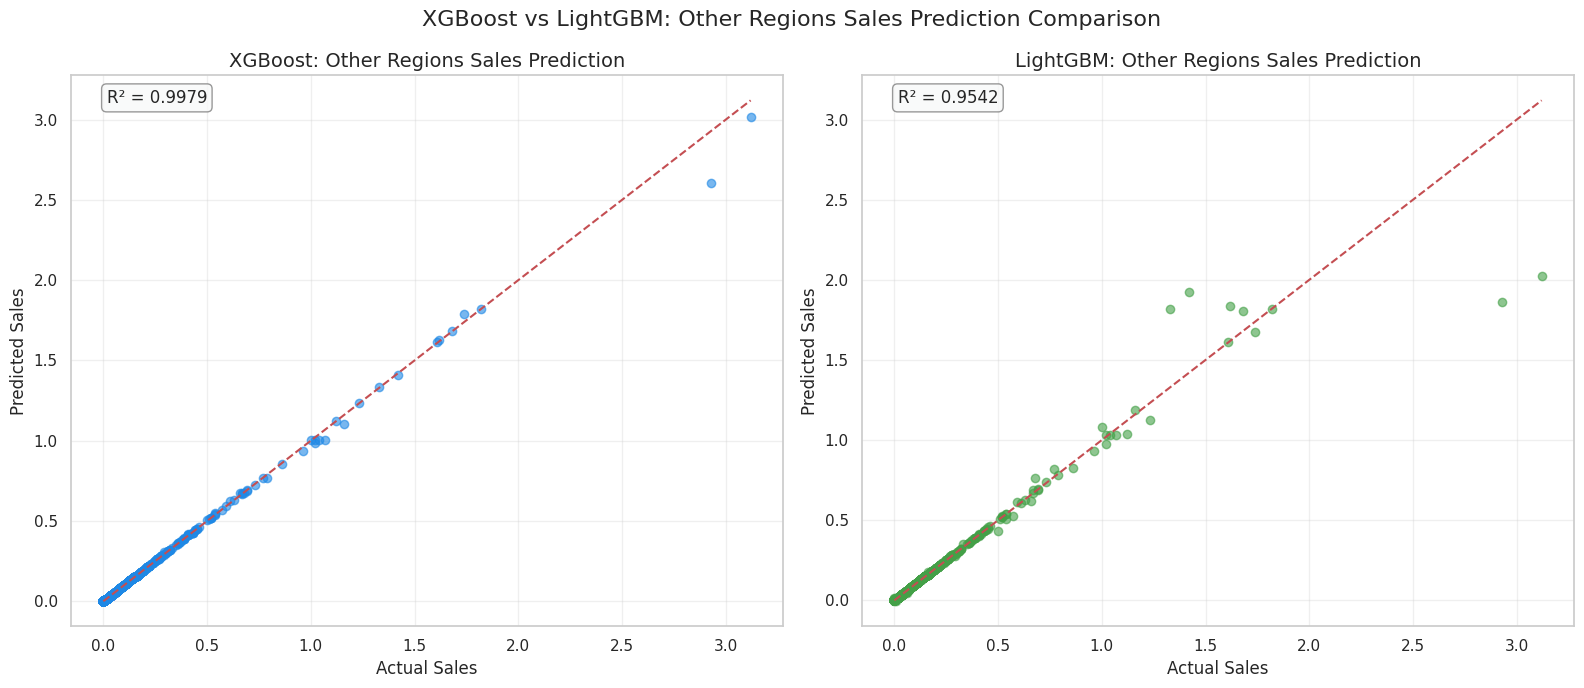

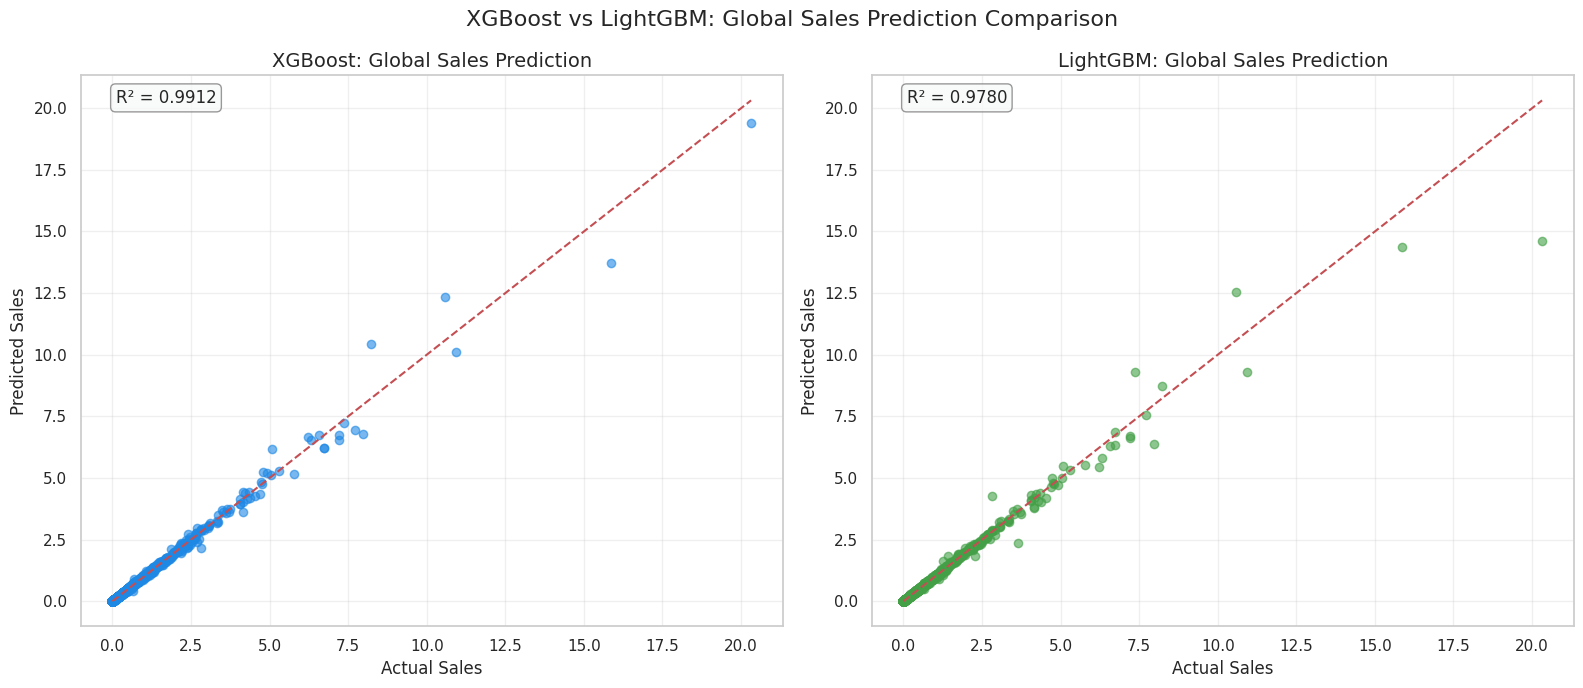

In [37]:
# Generate comparison plots for each region
print("Generating model comparison visualizations...")
plot_model_comparison(y_test_na, pred_na, lgb_pred_na, "North America")
plot_model_comparison(y_test_eu, pred_eu, lgb_pred_eu, "Europe")
plot_model_comparison(y_test_jp, pred_jp, lgb_pred_jp, "Japan")
plot_model_comparison(y_test_other, pred_other, lgb_pred_other, "Other Regions")
plot_model_comparison(y_test_global, pred_global, lgb_pred_global, "Global")

Cross-Validation (k-Fold)



In [38]:
from sklearn.model_selection import KFold, cross_val_score

# cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 📦 Cross-validation for NA Sales
cv_scores_na = cross_val_score(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    data[top_features],
    y_na,
    scoring='r2',
    cv=kfold
)
print(" 5-Fold CV R² Scores (North America):", cv_scores_na)
print("Mean R² Score (North America):", np.mean(cv_scores_na))


#Cross-validation for EU Sales
cv_scores_eu = cross_val_score(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    data[top_features],
    y_eu,
    scoring='r2',
    cv=kfold
)
print("\n5-Fold CV R² Scores (Europe):", cv_scores_eu)
print("Mean R² Score (Europe):", np.mean(cv_scores_eu))


# Cross-validation for JP Sales
cv_scores_jp = cross_val_score(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    data[top_features],
    y_jp,
    scoring='r2',
    cv=kfold
)
print("\n 5-Fold CV R² Scores (Japan):", cv_scores_jp)
print("Mean R² Score (Japan):", np.mean(cv_scores_jp))


# Cross-validation for Other Sales
cv_scores_other = cross_val_score(
    xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    data[top_features],
    y_other,
    scoring='r2',
    cv=kfold
)
print("\n 5-Fold CV R² Scores (Other Region):", cv_scores_other)
print("Mean R² Score (Other Region):", np.mean(cv_scores_other))


 5-Fold CV R² Scores (North America): [0.98526592 0.98601972 0.96919523 0.98262364 0.98571536]
Mean R² Score (North America): 0.9817639752359077

5-Fold CV R² Scores (Europe): [0.99705314 0.99872995 0.9992223  0.99871575 0.99902614]
Mean R² Score (Europe): 0.9985494558772527

 5-Fold CV R² Scores (Japan): [0.99981716 0.99957781 0.9994928  0.99970591 0.9967015 ]
Mean R² Score (Japan): 0.9990590342681533

 5-Fold CV R² Scores (Other Region): [0.9979448  0.99953494 0.99792843 0.9978737  0.99233956]
Mean R² Score (Other Region): 0.9971242860064431


Hyperparameter Tuning — GridSearchCV for All Regions

In [39]:
from sklearn.model_selection import GridSearchCV

#Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.9, 1]
}

# GridSearch for NA Sales
grid_search_na = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_search_na.fit(X_train_na, y_train_na)
print("\n Best Params (NA):", grid_search_na.best_params_)
print(" Best CV R² Score (NA):", grid_search_na.best_score_)


# GridSearch for EU Sales
grid_search_eu = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_search_eu.fit(X_train_eu, y_train_eu)
print("\n Best Params (EU):", grid_search_eu.best_params_)
print(" Best CV R² Score (EU):", grid_search_eu.best_score_)


# GridSearch for JP Sales
grid_search_jp = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_search_jp.fit(X_train_jp, y_train_jp)
print("\nBest Params (JP):", grid_search_jp.best_params_)
print("Best CV R² Score (JP):", grid_search_jp.best_score_)


# GridSearch for Other Sales
grid_search_other = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_search_other.fit(X_train_other, y_train_other)
print("\nBest Params (Other):", grid_search_other.best_params_)
print(" Best CV R² Score (Other):", grid_search_other.best_score_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits

 Best Params (NA): {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
 Best CV R² Score (NA): 0.9771549930535444
Fitting 3 folds for each of 81 candidates, totalling 243 fits

 Best Params (EU): {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}
 Best CV R² Score (EU): 0.9978829312050198
Fitting 3 folds for each of 81 candidates, totalling 243 fits

Best Params (JP): {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}
Best CV R² Score (JP): 0.9990997822319972
Fitting 3 folds for each of 81 candidates, totalling 243 fits

Best Params (Other): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}
 Best CV R² Score (Other): 0.9971254467553544


Visualization of Actual vs Predicted Sales


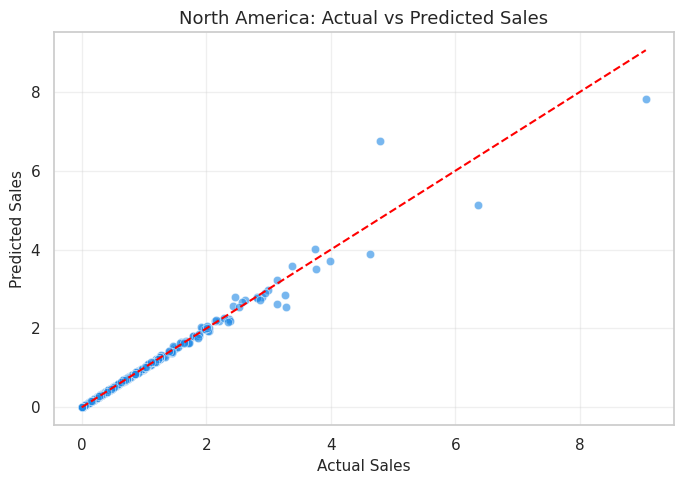

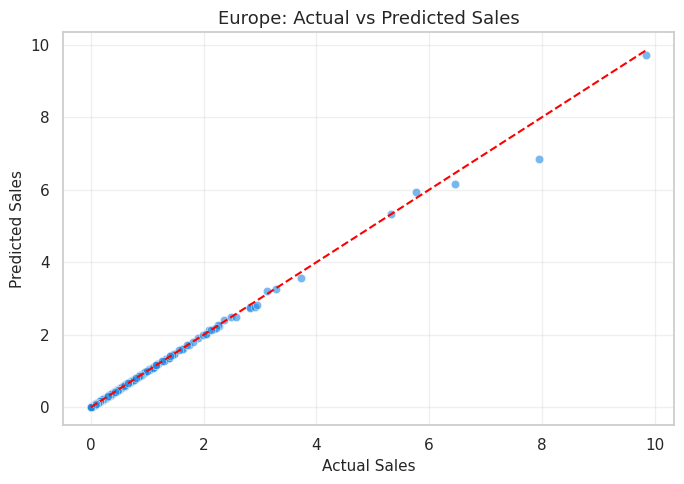

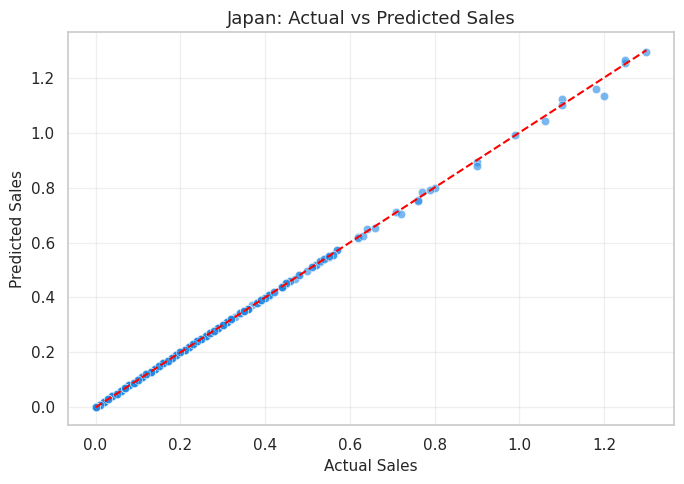

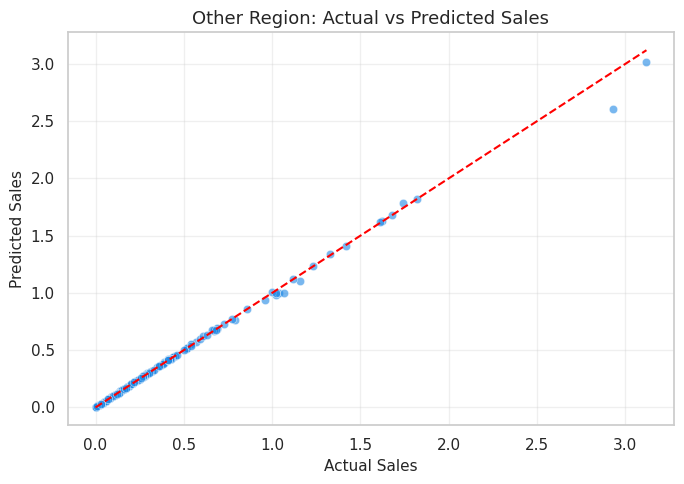

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

sns.set(style="whitegrid")

def plot_predictions(results_df, actual_col='Actual', predicted_col='Predicted', title=''):
    fig, ax = plt.subplots(figsize=(7, 5))  # smaller than previous 10x6

    # Scatter plot
    sns.scatterplot(data=results_df, x=actual_col, y=predicted_col, alpha=0.6, ax=ax, color='#1E88E5')

    # Perfect prediction line
    ax.plot([results_df[actual_col].min(), results_df[actual_col].max()],
            [results_df[actual_col].min(), results_df[actual_col].max()],
            color='red', linestyle='--')

    # Titles and labels
    ax.set_title(title, fontsize=13)
    ax.set_xlabel('Actual Sales', fontsize=11)
    ax.set_ylabel('Predicted Sales', fontsize=11)
    ax.grid(True, alpha=0.3)


    plt.tight_layout()
# Create DataFrames for predictions
results_df_na = pd.DataFrame({'Actual': y_test_na, 'Predicted': pred_na})
results_df_eu = pd.DataFrame({'Actual': y_test_eu, 'Predicted': pred_eu})
results_df_jp = pd.DataFrame({'Actual': y_test_jp, 'Predicted': pred_jp})
results_df_other = pd.DataFrame({'Actual': y_test_other, 'Predicted': pred_other})

# Visualize predictions for each region
plot_predictions(results_df_na, title="North America: Actual vs Predicted Sales")
plot_predictions(results_df_eu, title="Europe: Actual vs Predicted Sales")
plot_predictions(results_df_jp, title="Japan: Actual vs Predicted Sales")
plot_predictions(results_df_other, title="Other Region: Actual vs Predicted Sales")


Prediction Samples (Predicted vs Actual)

In [41]:
# 📦 Display a few predicted vs actual values
results_df = pd.DataFrame({
    'Actual NA Sales': y_test_na,
    'Predicted NA Sales': pred_na
})

results_df.head(10)


,Actual NA Sales,Predicted NA Sales
2572,0.48,0.474294
3144,0.40,0.399310
409,1.51,1.526487
15728,0.00,0.000015
12943,0.05,0.049999
322,0.86,0.847294
10847,0.08,0.079979
3777,0.00,0.000096
7591,0.10,0.099968
9713,0.00,0.000015


Plot Learning Curves for Each Trained Model

In [46]:
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='r2',
        train_sizes=np.linspace(0.1, 1.0, 8),
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(10,7))  # Bigger clearer plot
    plt.plot(train_sizes, train_mean, 'o-', label='Training R²', color='blue')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation R²', color='green')

    plt.fill_between(train_sizes, train_mean - np.std(train_scores, axis=1),
                     train_mean + np.std(train_scores, axis=1), alpha=0.1, color='blue')
    plt.fill_between(train_sizes, val_mean - np.std(val_scores, axis=1),
                     val_mean + np.std(val_scores, axis=1), alpha=0.1, color='green')

    plt.title(f'Learning Curve: {title}', fontsize=16)
    plt.xlabel('Training Set Size', fontsize=14)
    plt.ylabel('R² Score', fontsize=14)
    plt.ylim(0.5, 1.02)  # 👈 Adjusted Y-axis range
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


overfitting/underfitting

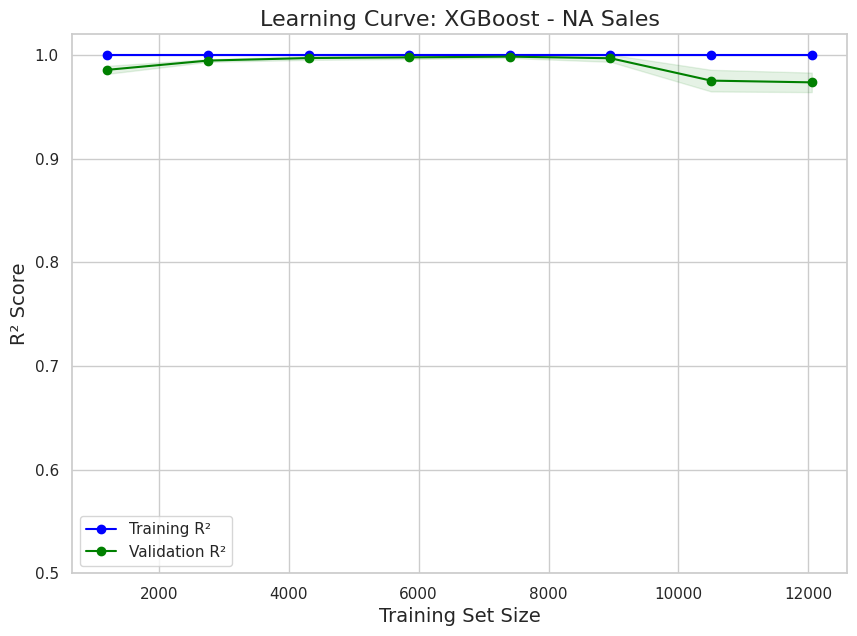

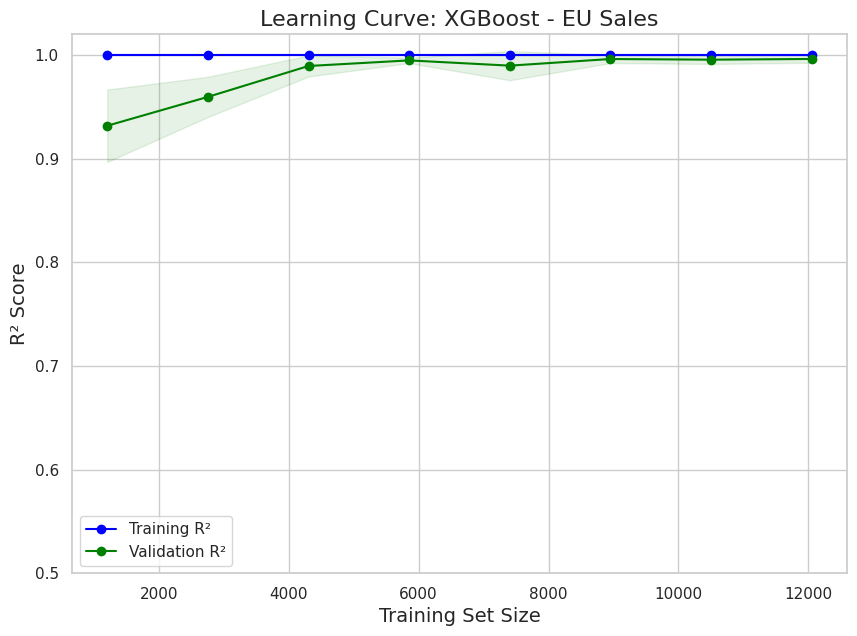

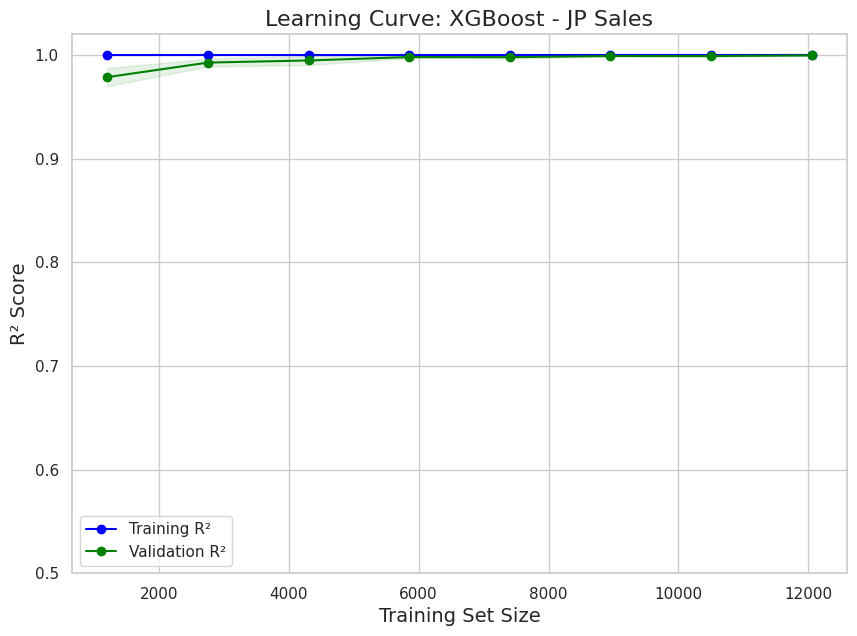

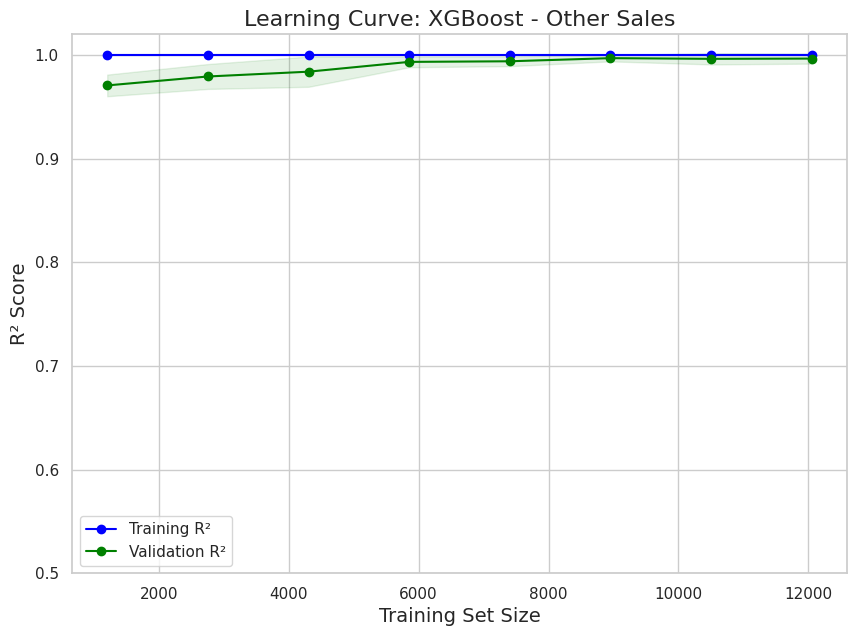

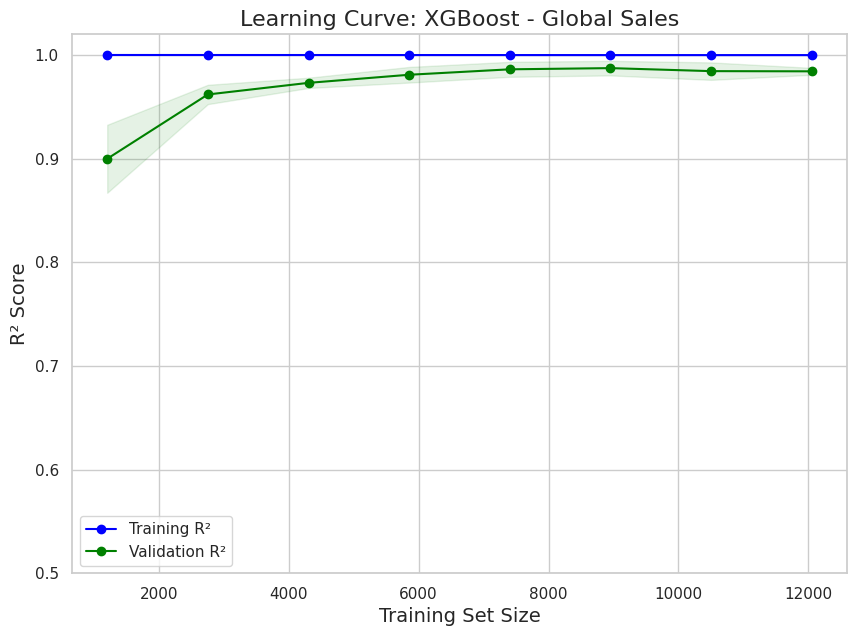

In [47]:
plot_learning_curve(xg_na, X_train_na, y_train_na, 'XGBoost - NA Sales')
plot_learning_curve(xg_eu, X_train_eu, y_train_eu, 'XGBoost - EU Sales')
plot_learning_curve(xg_jp, X_train_jp, y_train_jp, 'XGBoost - JP Sales')
plot_learning_curve(xg_other, X_train_other, y_train_other, 'XGBoost - Other Sales')
plot_learning_curve(xg_global, X_train_global, y_train_global, 'XGBoost - Global Sales')
